In [100]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/miscentering/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

## Import catalogs

In [185]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = homedir +'output/buzzard/halo_shape/halo_shape_redM_matched_v1.2.npy'
redM_shape = np.load(filename)
redM_shape = redM_shape.view(np.recarray)

print "Number of halos in the redM catalog is ", len(redM_shape)
print redM_shape.dtype

#Apply mass cut
#masscut = np.where(redM_data.M200b > 1e13)
#redM_data = redM_data[masscut]
print "After mass cut number of halos is ", len(redM_shape)

Number of halos in the redM catalog is  18463
(numpy.record, [('halos_ID', '<i4'), ('matching_ID', '<i4'), ('Rvir', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('converge', '<i4')])
After mass cut number of halos is  18463


In [186]:
#Miscentering cut
import pickle

#Loading the centered/miscentered halo IDs
matched_redM = homedir + 'output/buzzard/redM_matched_v1.2.data'
matched_halos = homedir + 'output/buzzard/halos_matched_v1.2.data'

infile = open(matched_redM,'rb')
matched_redM = pickle.load(infile)

infile = open(matched_halos,'rb')
redM_halos = pickle.load(infile)

redM_halos = redM_halos.view(np.recarray)
matched_redM = matched_redM.view(np.recarray)

## Match and divide shape file into centered/miscentered

In [187]:
#Apply cuts
#mass cut
mcut = np.where(redM_halos.M200B >= 1e13)
redM_halos = redM_halos[mcut]
matched_redM = matched_redM[mcut]
print "After mass cut matched halos has num ", len(redM_halos)

#Redshift cut
zcut = np.where(redM_halos.Z <= 0.90)
redM_halos = redM_halos[zcut]
matched_redM = matched_redM[zcut]
print "After z cut matched halos has num ", len(redM_halos)

#Converge cut
convcut = np.where(redM_shape.converge == True)
redM_shape = redM_shape[convcut]
print "After convcut redM-shape has num ", len(redM_shape)

#Shape has repeating halos. 
unique_ID, unique_ind = np.unique(redM_shape.halos_ID, return_index=True)
redM_shape = redM_shape[unique_ind]


After mass cut matched halos has num  18463
After z cut matched halos has num  18462
After convcut redM-shape has num  18011


In [188]:
cent_ind = np.where(matched_redM['centered_flag'] == 1)
miscent_ind = np.where(matched_redM['centered_flag'] == 0)

redM_cent = matched_redM[cent_ind]
halos_cent = redM_halos[cent_ind]
redM_miscent = matched_redM[miscent_ind]
halos_miscent = redM_halos[miscent_ind]

redM_cent = redM_cent.view(np.recarray)
redM_miscent = redM_miscent.view(np.recarray)
halos_cent = halos_cent.view(np.recarray)
halos_miscent = halos_miscent.view(np.recarray)
redM_halos = redM_halos.view(np.recarray)
matched_redM = matched_redM.view(np.recarray)

In [189]:
#np.searchsorted to match by matching_ID
#then create sub_arrays redM_cent_shape. redM_miscent_shape

cent_bool = np.isin(halos_cent.HALOID, redM_shape.halos_ID)
cent_ind = np.where(cent_bool == True)[0]
redM_cent = redM_cent[cent_ind]
halos_cent = halos_cent[cent_ind]

miscent_bool = np.isin(halos_miscent.HALOID, redM_shape.halos_ID)
miscent_ind = np.where(miscent_bool == True)[0]
redM_miscent = redM_miscent[miscent_ind]
halos_miscent = halos_miscent[miscent_ind]

#Sorting 
sort_idx = redM_shape_cent.matching_ID.argsort()
sort_idx = sort_idx[np.searchsorted(redM_shape_cent.matching_ID, redM_cent.matching_ID, sorter = sort_idx)]
redM_shape_cent = redM_shape_cent[sort_idx]

sort_idx = redM_shape_miscent.matching_ID.argsort()
sort_idx = sort_idx[np.searchsorted(redM_shape_miscent.matching_ID, redM_miscent.matching_ID, sorter = sort_idx)]
redM_shape_miscent = redM_shape_miscent[sort_idx]

#print len(redM_shape_cent), len(redM_shape_miscent), len(redM_shape)
#print redM_shape.matching_ID
#print matched_redM.matching_ID

print len(redM_miscent), len(redM_shape_miscent)
print len(redM_cent), len(redM_shape_cent)
print len(redM_shape_cent) + len(redM_shape_miscent)

7752 7752
10258 10258
18010


### Extracting info from centered

In [107]:
##Shorthand name for relevant halo/redM parameters
print "Before convergence cut number of halos is ", len(redM_cent)
halos_ID_cent, q_cent, s_cent, cos_i_cent = read_shape_param(np.array(redM_shape_cent), convcut=True)
#Choose only convergent halos
conv_cut = [i for (i,x) in enumerate(redM_shape_cent.halos_ID) if x in halos_ID_cent]
redM_shape_cent = redM_shape_cent[conv_cut]
print "After convergence cut number of halos is ", len(redM_cent)

richness = redM_cent.LAMBDA_CHISQ
halos_M  = halos_cent.M200B

coord_cent = np.zeros( (len(redM_cent),2))
coord_cent[:,0] = redM_cent.RA; coord_cent[:,1] = redM_cent.DEC

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Before convergence cut number of halos is  10258
After convergence cut number of halos is  10258
Halo mass range is from  13.025960909856378 15.356618541969091


### Binning by cos(i) and \lambda

In [108]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_cent = halo_bin_stat(cos_i_cent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_cent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_cent))]

Maximum richness after cuts is  303.04428


In [109]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned_cent = [None]*num_bins
lnl_binned_cent = [None]*num_bins

lnl_cent = np.log(richness)
lnM200b_cent = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned_cent[i] = np.log(halos_M[cosi_bins_ind_cent[i]])
    lnl_binned_cent[i] = np.log(richness[cosi_bins_ind_cent[i]])

### Extracting info from miscentered

In [110]:
##Shorthand name for relevant halo/redM parameters
print "Before convergence cut number of halos is ", len(redM_miscent)
halos_ID_miscent, q_miscent, s_miscent, cos_i_miscent = read_shape_param(np.array(redM_shape_miscent), convcut=True)
#Choose only convergent halos
conv_cut = [i for (i,x) in enumerate(redM_shape_miscent.halos_ID) if x in halos_ID_miscent]
redM_shape_miscent = redM_shape_miscent[conv_cut]
print "After convergence cut number of halos is ", len(redM_shape_miscent)

richness = redM_miscent.LAMBDA_CHISQ
halos_M  = halos_miscent.M200B

coord_miscent = np.zeros( (len(redM_miscent),2))
coord_miscent[:,0] = redM_miscent.RA; coord_miscent[:,1] = redM_miscent.DEC

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Before convergence cut number of halos is  7752
After convergence cut number of halos is  7752
Halo mass range is from  13.000564216165376 15.53186194909581


In [111]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_miscent = halo_bin_stat(cos_i_miscent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_miscent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_miscent))]

Maximum richness after cuts is  288.2012


In [112]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned_miscent = [None]*num_bins
lnl_binned_miscent = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned_miscent[i] = np.log(halos_M[cosi_bins_ind_miscent[i]])
    lnl_binned_miscent[i] = np.log(richness[cosi_bins_ind_miscent[i]])

## Shape information

### Statistical information

In [113]:
km_ncen = 40

#centered
all_ind = [np.arange(len(q_cent))]
q_cent_se, q_cent_mean = kmeans_stats(km_ncen, coord_cent, q_cent, all_ind)
s_cent_se, s_cent_mean = kmeans_stats(km_ncen, coord_cent, s_cent, all_ind)
cosi_cent_se, cosi_cent_mean = kmeans_stats(km_ncen, coord_cent, cos_i_cent, all_ind)

#miscentered
all_ind = [np.arange(len(q_miscent))]
q_miscent_se, q_miscent_mean = kmeans_stats(km_ncen, coord_miscent, q_miscent, all_ind)
s_miscent_se, s_miscent_mean = kmeans_stats(km_ncen, coord_miscent, s_miscent, all_ind)
cosi_miscent_se, cosi_miscent_mean = kmeans_stats(km_ncen, coord_miscent, cos_i_miscent, all_ind)

/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


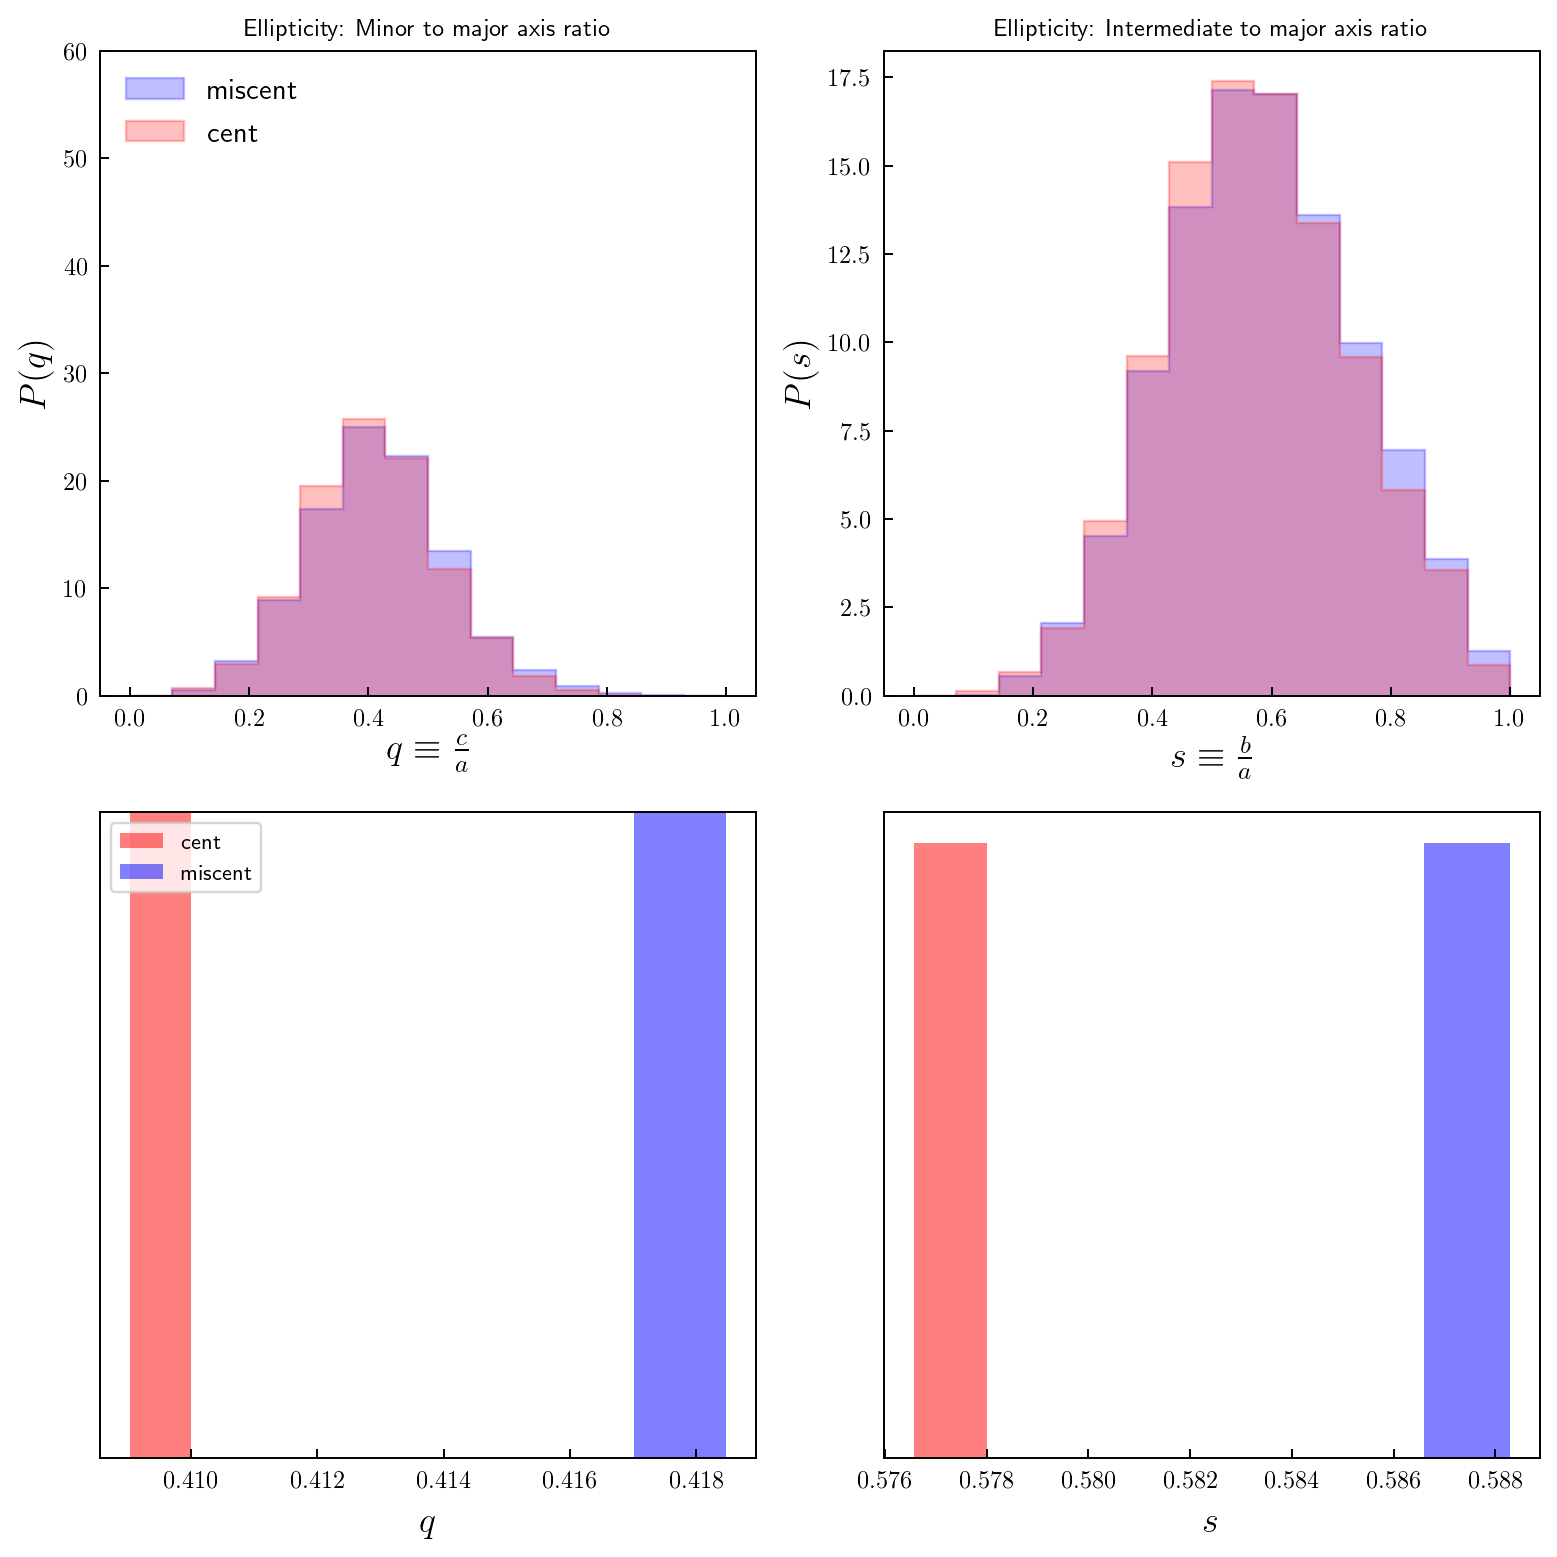

In [114]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(9,9))
num_bin = np.linspace(0.0,1.0,15)

#Plotting miscentered halos
weights = np.ones_like(q_miscent)/(len(q_miscent)) * 100
axs[0,0].hist(q_miscent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='blue', \
               label='miscent', alpha=0.25) 
weights = np.ones_like(s_miscent)/(len(s_miscent)) * 100
a =axs[0,1].hist(s_miscent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='blue', \
               label='miscent', alpha=0.25) 
    
    
#Plotting centered halos
weights = np.ones_like(q_cent)/(len(q_cent)) * 100
axs[0,0].hist(q_cent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='red', \
               label='cent', alpha=0.25) 
weights = np.ones_like(s_cent)/(len(s_cent)) * 100
a =axs[0,1].hist(s_cent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='red', \
               label='cent', alpha=0.25) 


#Plot config   
axs[0,0].set_xlabel(r'$q \equiv \frac{c}{a}$', size=15)
axs[0,0].set_ylabel('$P(q)$', size=15)
axs[0,0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)

axs[0,0].set_ylim((0,60))
axs[0,0].legend(loc='upper left', fontsize=12, frameon=False)

axs[0,1].set_xlabel(r'$s \equiv \frac{b}{a}$', size=15)
axs[0,1].set_ylabel('$P(s)$', size=15)
axs[0,1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
#plt.savefig('ellipticity_dist_053018.png')


#Plotting the mean q, s

#Plot config
num_bins = len(cosi_bins)
yticks = np.linspace(0.2,0.8 , num_bins)
yticklabels = []
xlabels = [r'$q$', r'$s$', r'$\cos(i)$']
for i, cosi_bin_i in enumerate(cosi_bins):
    yticklabels_i = r'$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_i[0], cosi_bin_i[1])
    yticklabels.append(yticklabels_i)
    
#Plotting mean q,s with errors    
axs[1,0].bar(q_cent_mean, height=1, width=q_cent_se, alpha=0.5, color='red',label='cent')
axs[1,0].bar(q_miscent_mean, height=1, width=q_miscent_se, alpha=0.5, color='blue',label='miscent')
axs[1,1].bar(s_cent_mean, height=1, width=s_cent_se, alpha=0.5, color='red',label='cent')
axs[1,1].bar(s_miscent_mean, height=1, width=s_miscent_se, alpha=0.5, color='blue',label='miscent')

axs[1,1].set_xlabel(xlabels[1], size=15)
axs[1,0].set_xlabel(xlabels[0], size=15)
axs[1,1].set_yticks([])
axs[1,0].set_ylim((0.0,1.0))

#Legend and ticklabels
axs[1,0].legend(fontsize=9, loc='upper left')
axs[1,0].set_yticks([])
#axs[1,0].set_yticks(yticks)
#axs[1,0].set_yticklabels(yticklabels, fontsize=15)

    
plt.show()   

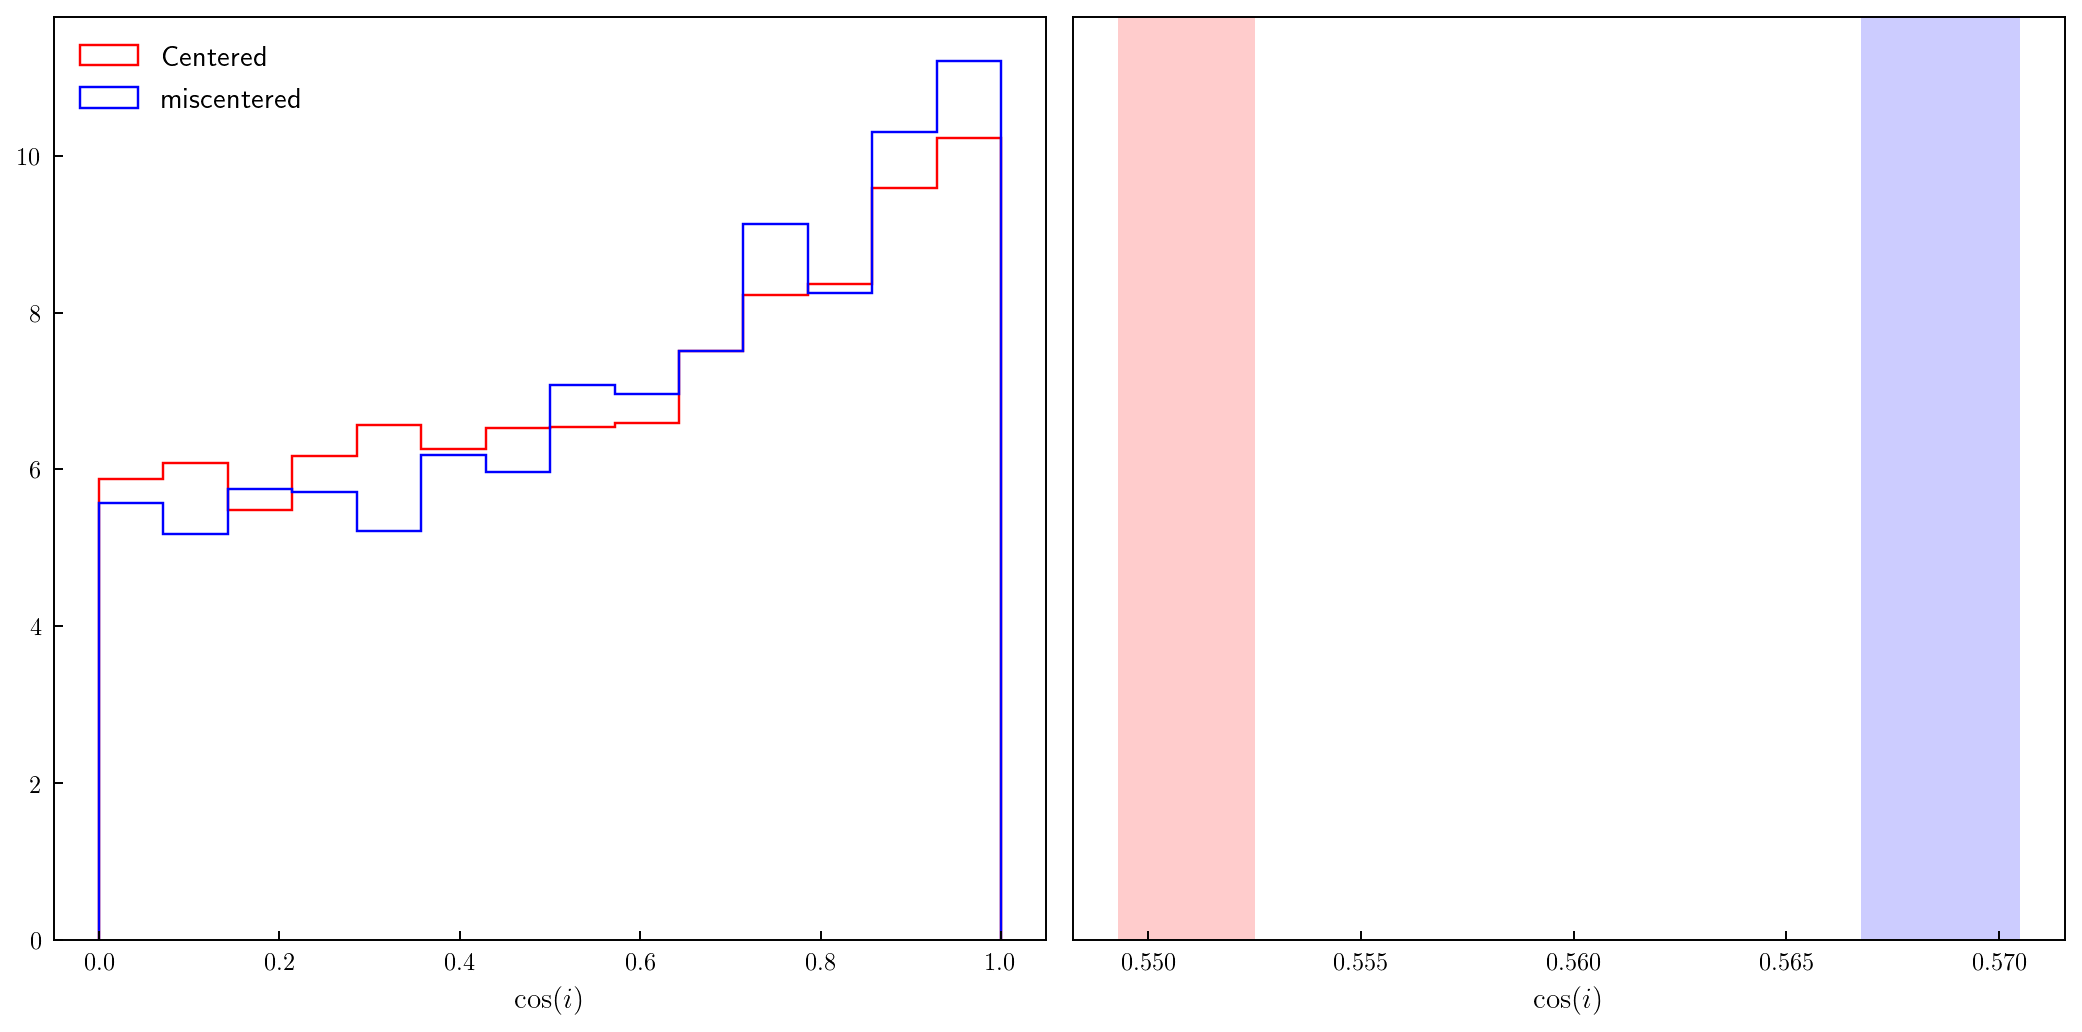

In [115]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12,6))
num_bin = np.linspace(0.0,1.0,15)

####Centered halos########
weights_cent = np.ones_like(cos_i_cent, dtype=float)/len(cos_i_cent)* 100
axs[0].hist(cos_i_cent, num_bin, density=False, fill=False, weights=weights_cent, histtype='step', label="Centered", color='red') 
axs[1].bar(cosi_cent_mean, height=1, width=cosi_cent_se, alpha=0.2, color='red',label='cent')

####miscentered halos########
lmda_bin_num = len(lmda_bins_ind_miscent)
weights_miscent = np.ones_like(cos_i_miscent, dtype=float)/len(cos_i_miscent)* 100
axs[0].hist(cos_i_miscent, num_bin, density=False, fill=False, weights=weights_miscent, histtype='step', label="miscentered", color='blue') 
axs[1].bar(cosi_miscent_mean, height=1, width=cosi_miscent_se, alpha=0.2, color='blue',label='miscent')



axs[0].set_xlabel(xlabels[2], fontsize=12)
axs[1].set_xlabel(xlabels[2], fontsize=12)
axs[1].set_yticks([])
axs[1].set_ylim((0.0,1.0))
    

#axs.set_ylim((0,60))
axs[0].legend(loc='upper left', fontsize=12, frameon=False)

plt.show()
    

## $\Delta \lambda$ vs $\cos{(i)}$

### Importing hrun and matching

In [151]:
from tools.setup.setup import data_home_dir, home_dir
import astropy.io.fits as fits
datadir = data_home_dir()
homedir = home_dir()
hrun_dir = datadir + 'halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto_fullhalo_final_chto.fit'
hrun_list = fits.open(hrun_dir)
hrun_data = hrun_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in hrun_data are: \n"
print hrun_data.names

#Converting FITS files into record array
hrun_data = np.array(hrun_data, dtype=hrun_data.dtype)
hrun_data = hrun_data.view(np.recarray)

print "\n Number of halos is", len(hrun_data)

Names of columns in hrun_data are: 

['HALOID', 'Mvir', 'R200', 'MEM_MATCH_ID', 'RA', 'DEC', 'Z', 'P_BCG', 'Z_LAMBDA', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD', 'ra_cent', 'dec_cent', 'p_cen', 'p_sat', 'ID_CENT', 'M200B']

 Number of halos is 144508


In [152]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = homedir +'output/buzzard/halo_shape/halo_shape_redM_matched_v1.2.npy'
redM_shape = np.load(filename)
redM_shape = redM_data.view(np.recarray)

print "Number of halos in the redM catalog is ", len(redM_shape)
print redM_shape.dtype

#Apply mass cut
#masscut = np.where(redM_data.M200b > 1e13)
#redM_data = redM_data[masscut]
print "After mass cut number of halos is ", len(redM_shape)

Number of halos in the redM catalog is  18463
(numpy.record, [('halos_ID', '<i4'), ('matching_ID', '<i4'), ('Rvir', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('converge', '<i4')])
After mass cut number of halos is  18463


In [153]:
#Miscentering cut
import pickle

#Loading the centered/miscentered halo IDs
matched_redM = homedir + 'output/buzzard/redM_matched_v1.2.data'
matched_halos = homedir + 'output/buzzard/halos_matched_v1.2.data'

infile = open(matched_redM,'rb')
matched_redM = pickle.load(infile)

infile = open(matched_halos,'rb')
redM_halos = pickle.load(infile)

redM_halos = redM_halos.view(np.recarray)
matched_redM = matched_redM.view(np.recarray)

## Cuts

In [157]:
#Apply cuts
#mass cut
mcut = np.where(redM_halos.M200B >= 1e13)
redM_halos = redM_halos[mcut]
matched_redM = matched_redM[mcut]
print "After mass cut matched halos has num ", len(redM_halos)

#Redshift cut
zcut = np.where(redM_halos.Z <= 0.90)
redM_halos = redM_halos[zcut]
matched_redM = matched_redM[zcut]
print "After z cut matched halos has num ", len(redM_halos)

#Converge cut
convcut = np.where(redM_shape.converge == True)
redM_shape = redM_shape[convcut]
print "After convcut redM-shape has num ", len(redM_shape)

#Shape has repeating halos. 
unique_ID, unique_ind = np.unique(redM_shape.halos_ID, return_index=True)
redM_shape = redM_shape[unique_ind]

After mass cut matched halos has num  18010
After z cut matched halos has num  18010
After convcut redM-shape has num  18010


## Shape filter

In [159]:
#np.searchsorted to match by matching_ID
#then create sub_arrays redM_cent_shape. redM_miscent_shape
unique_ID, unique_ind = np.unique(redM_shape.halos_ID, return_index=True)
redM_shape = redM_shape[unique_ind]

shape_bool = np.isin(redM_halos.HALOID, redM_shape.halos_ID)
shape_ind = np.where(shape_bool == True)[0]
redM_halos = redM_halos[shape_ind]
matched_redM = matched_redM[shape_ind]

print len(redM_halos), len(redM_shape)

18010 18010


### Hrun filter

In [162]:
#Halo_Run catalog has repeating halos. Clean that up
unique_ID, unique_ind = np.unique(hrun_data.HALOID, return_index=True)
hrun_data = hrun_data[unique_ind]

#Match shape, redM_halos to hrun
print "Before halocut but after mass cut number of halos in redM_shape is ", len(redM_shape)
hrun_bool = np.isin(redM_shape.halos_ID, hrun_data.HALOID)
hruncut = np.where(hrun_bool == True)[0]
redM_shape = redM_shape[hruncut]
print "After halocut number of halos in redM_shape is ", len(redM_shape)

print "Before halocut but after mass cut number of halos in redM_halos is ", len(redM_halos)
hrun_bool = np.isin(redM_halos.HALOID, hrun_data.HALOID)
hruncut = np.where(hrun_bool == True)[0]
redM_halos = redM_halos[hruncut]
matched_redM = matched_redM[hruncut]
print "After halocut number of halos in redM_halos is ", len(redM_halos)


#Match hrun to other catalogs
print "Before halocut but after mass cut number of halos in hrun_data is ", len(hrun_data)
hrun_bool = np.isin(hrun_data.HALOID, redM_shape.halos_ID)
hruncut = np.where(hrun_bool == True)[0]
hrun_data = hrun_data[hruncut]
print "After halocut number of halos in hrun_data is ", len(hrun_data)


Before halocut but after mass cut number of halos in redM_shape is  15967
After halocut number of halos in redM_shape is  15967
Before halocut but after mass cut number of halos in redM_halos is  15967
After halocut number of halos in redM_halos is  15967
Before halocut but after mass cut number of halos in hrun_data is  15967
After halocut number of halos in hrun_data is  15967


### Sorting by ID

In [164]:
#Sort the arrays by order of ID. That way the indices match. 

#For hrun
ID_sort = np.argsort(hrun_data.HALOID)
hrun_data = hrun_data[ID_sort]
print "After sorting, IDs in hrun are: "
print hrun_data.HALOID, "\n"

#For redM_halos
ID_sort = np.argsort(redM_halos.HALOID)
redM_halos = redM_halos[ID_sort]
matched_redM = matched_redM[ID_sort]
print "After sorting, IDs in redM_halos are: "
print redM_halos.HALOID, "\n"

#For shape
ID_sort = np.argsort(redM_shape.halos_ID)
redM_shape = redM_shape[ID_sort]
print "After sorting, IDs in redM_shape are: "
print redM_shape.halos_ID, "\n"

After sorting, IDs in hrun are: 
[  2184825   2203138   2203220 ... 139863695 140394619 140449099] 

After sorting, IDs in redM_halos are: 
[  2184825   2203138   2203220 ... 139863695 140394619 140449099] 

After sorting, IDs in redM_shape are: 
[  2184825   2203138   2203220 ... 139863695 140394619 140449099] 



## Divide into center and miscenter

In [165]:
cent_ind = np.where(matched_redM['centered_flag'] == 1)
miscent_ind = np.where(matched_redM['centered_flag'] == 0)

redM_cent = matched_redM[cent_ind]
halos_cent = redM_halos[cent_ind]
hrun_cent = hrun_data[cent_ind]

redM_miscent = matched_redM[miscent_ind]
halos_miscent = redM_halos[miscent_ind]
hrun_miscent = hrun_data[miscent_ind]

redM_cent = redM_cent.view(np.recarray)
redM_miscent = redM_miscent.view(np.recarray)
halos_cent = halos_cent.view(np.recarray)
halos_miscent = halos_miscent.view(np.recarray)
redM_halos = redM_halos.view(np.recarray)
matched_redM = matched_redM.view(np.recarray)
hrun_miscent = hrun_miscent.view(np.recarray)
hrun_cent = hrun_cent.view(np.recarray)

### Shape info

In [166]:
##Shorthand name for relevant halo/redM parameters
halos_ID, q, s, cos_i = read_shape_param(np.array(redM_shape), convcut=True)
#Choose only convergent halos
conv_cut = [i for (i,x) in enumerate(redM_shape.halos_ID) if x in halos_ID]
redM_shape = redM_shape[conv_cut]
print "After convergence cut number of halos is ", len(redM_shape)

richness = redM_halos_halocut.richness
halos_M  = redM_halos_halocut.M200b

After convergence cut number of halos is  15967


### Miscentered Distance

In [167]:
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

#For the Chinchilla catalog
halos_matched_d = cosmo.comoving_distance(redM_halos.Z)
redM_coord = SkyCoord(matched_redM.RA*u.deg, matched_redM.DEC*u.deg, distance=halos_matched_d, frame='icrs')
halos_matched_coord = SkyCoord(hrun_data.RA*u.deg, hrun_data.DEC*u.deg, distance=halos_matched_d, frame='icrs')
miscenter_d_Chinchilla = halos_matched_coord.separation_3d(redM_coord)

#For the halo_run catalog
hrun_d = cosmo.comoving_distance(hrun_data.Z)
hrun_coord = SkyCoord(hrun_data.RA*u.deg, hrun_data.DEC*u.deg, distance=hrun_d, frame='icrs')
miscenter_d_hrun = hrun_coord.separation_3d(redM_coord)

In [168]:
#Convert 3D distance to R_lambda units
h=0.7
R_lambda = (matched_redM.LAMBDA_CHISQ/100)**(0.2)/h
#print R_lambda
dummy= np.argsort(R_lambda)



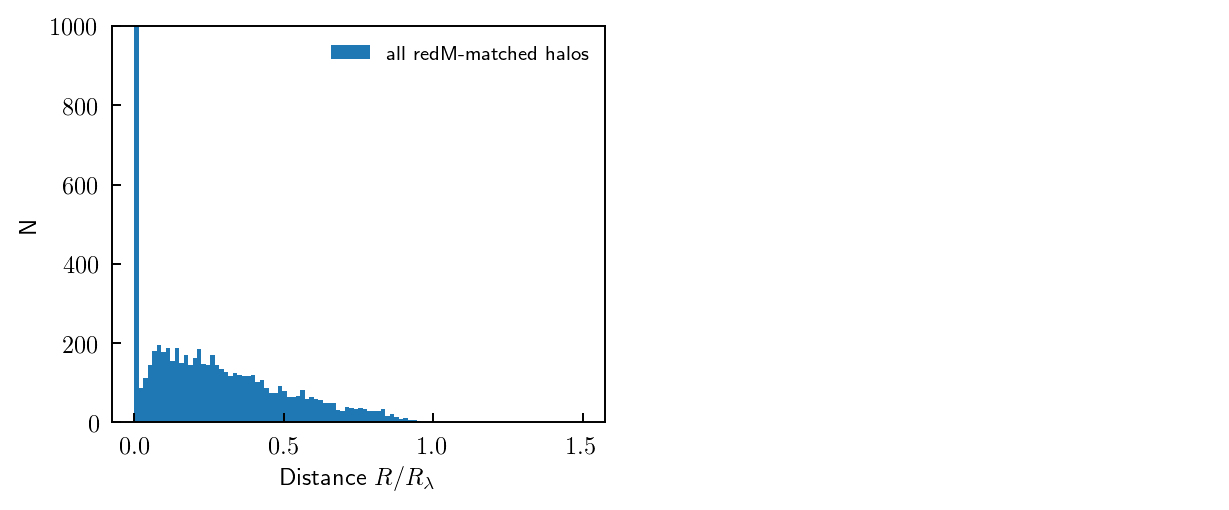

In [169]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
num_bin=100;
hist_range = (0,1.5)

#Plotting random halos
axs[0].hist(miscenter_d_Chinchilla/R_lambda, num_bin, range=hist_range, label='all redM-matched halos')
#axs[1].hist(miscenter_d_hrun/R_lambda, num_bin, range=hist_range, label='red-matched halos in hrun')

#Plot config   
#axs[0].set_ylim((0,6000))
axs[0].set_xlabel('Distance $R/R_\lambda$')
axs[0].set_ylabel('N')
#axs[0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)
axs[0].legend(loc='best', fontsize=8, frameon=False)
axs[0].set_ylim((0,1000))
'''
axs[1].set_xlabel(r'Distance $R/R_\lambda$')
axs[1].set_ylabel('N')
#axs[1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
axs[1].legend(loc='best', fontsize=8, frameon=False)
#plt.savefig('ellipticity_032018.png')
'''
axs[-1].axis('off')
plt.show()

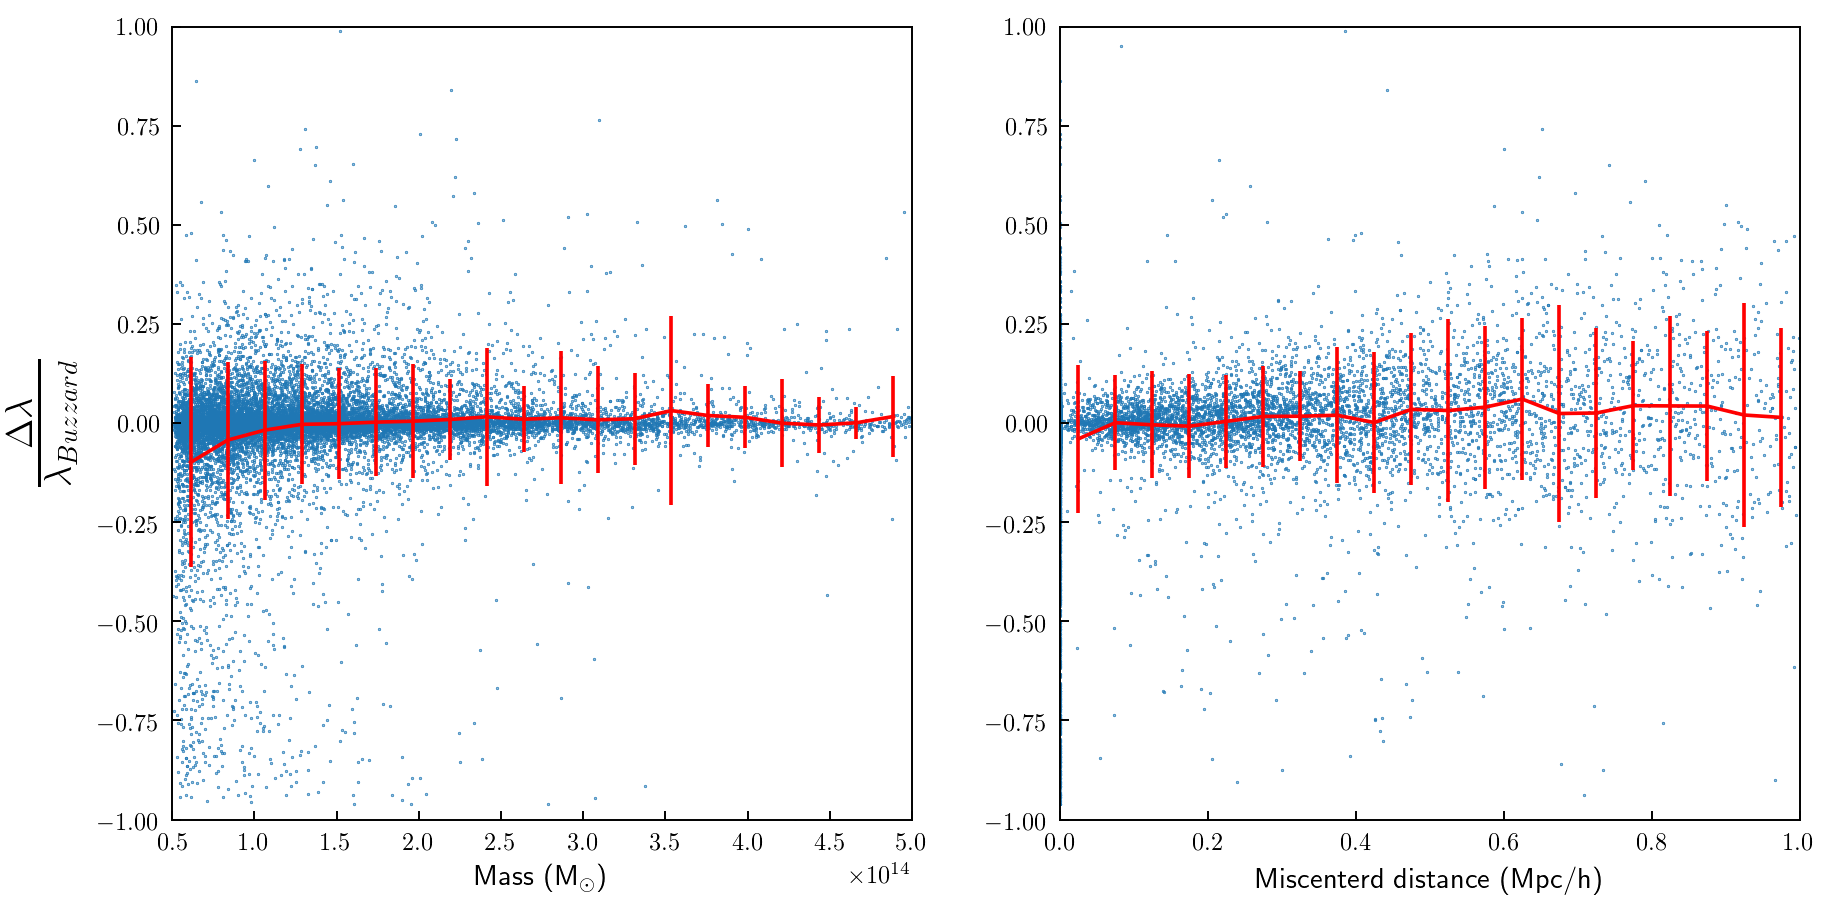

In [172]:
from scipy.stats import binned_statistic as bin_stat
delta_lambdafrac = np.float64(hrun_data.LAMBDA_CHISQ - matched_redM.LAMBDA_CHISQ)/matched_redM.LAMBDA_CHISQ

nbins = 20
dlmdafrac_range = (-1,1)
#error for mass
m_range = (5e13,5e14)
n, _ = np.histogram(hrun_data.M200B, bins=nbins, range=m_range)
sy, _ = np.histogram(hrun_data.M200B, bins=nbins, weights=delta_lambdafrac, range=m_range)
sy2, mass_bins = np.histogram(hrun_data.M200B, bins=nbins, weights=delta_lambdafrac**2., range=m_range)
lmda_mass_mean = sy / n
lmda_mass_std = np.sqrt(sy2/n - lmda_mass_mean**2.)

#error for miscentering
d_range = (0,1)
n, _ = np.histogram(miscenter_d_Chinchilla, bins=nbins, range=d_range)
sy, d_bins = np.histogram(miscenter_d_Chinchilla, bins=nbins, weights=delta_lambdafrac, range=d_range)
sy2, d_bins = np.histogram(miscenter_d_Chinchilla, bins=nbins, weights=delta_lambdafrac**2., range=d_range)
lmda_d_mean = sy / n
lmda_d_std = np.sqrt(sy2/n - lmda_d_mean**2.)

fig, ax = plt.subplots(1,2, figsize = (12,6))
#plt.tight_layout()
#Scatter plots
ax[0].scatter(hrun_data.M200B, delta_lambdafrac, s=0.1)
ax[0].errorbar((mass_bins[1:] + mass_bins[:-1])/2, lmda_mass_mean, yerr=lmda_mass_std, fmt='r-')
ax[1].scatter(miscenter_d_Chinchilla, delta_lambdafrac, s=0.1)
ax[1].errorbar((d_bins[1:] + d_bins[:-1])/2, lmda_d_mean, yerr=lmda_d_std, fmt='r-')
ax[0].set_xlim(m_range)
ax[1].set_xlim(d_range)
ax[0].set_ylim(dlmdafrac_range)
ax[1].set_ylim(dlmdafrac_range)

ax[0].set_ylabel(r'$\frac{\Delta\lambda}{\lambda_{Buzzard}}$', fontsize=22)
ax[0].set_xlabel(r'Mass (M$_\odot$)', fontsize=12)
ax[1].set_xlabel(r'Miscenterd distance (Mpc/h)', fontsize=12)

#Error plots
#For mass of hrun
#dLmda_mass_mean = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]
#dLmda_mass_stdev = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]

plt.show()

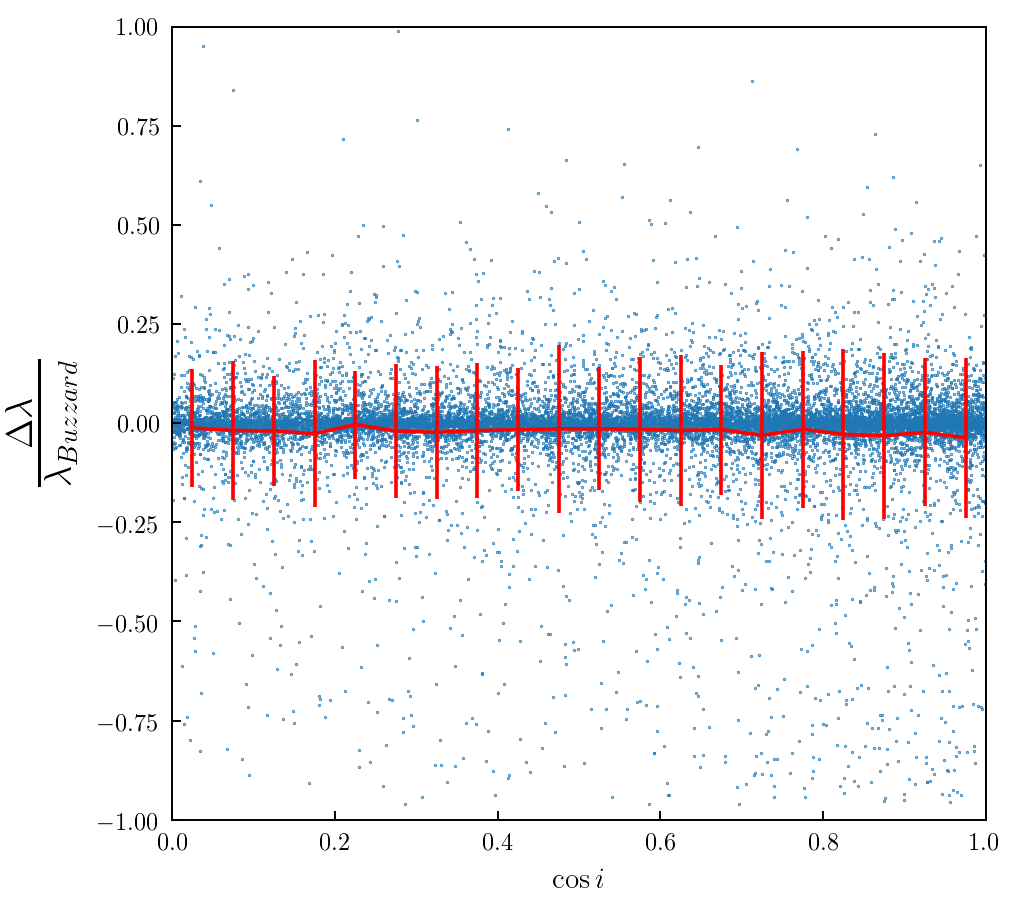

In [184]:
from scipy.stats import binned_statistic as bin_stat
delta_lambdafrac = np.float64(hrun_data.LAMBDA_CHISQ - matched_redM.LAMBDA_CHISQ)/matched_redM.LAMBDA_CHISQ

nbins = 20
dlmdafrac_range = (-1,1)
#error for mass
cosi_range = (0.0,1)
n, _ = np.histogram(cos_i, bins=nbins, range=cosi_range)
sy, _ = np.histogram(cos_i, bins=nbins, weights=delta_lambdafrac, range=cosi_range)
sy2, cosi_bins = np.histogram(cos_i, bins=nbins, weights=delta_lambdafrac**2., range=cosi_range)
lmda_cosi_mean = sy / n
lmda_cosi_std = np.sqrt(sy2/n - lmda_cosi_mean**2.)


fig, ax = plt.subplots(1,1, figsize = (6,6))
#plt.tight_layout()
#Scatter plots
ax.scatter(cos_i, delta_lambdafrac, s=0.1)
ax.errorbar((cosi_bins[1:] + cosi_bins[:-1])/2, lmda_cosi_mean, yerr=lmda_cosi_std, fmt='r-')
ax.set_xlim(cosi_range)
ax.set_ylim(dlmdafrac_range)

ax.set_ylabel(r'$\frac{\Delta\lambda}{\lambda_{Buzzard}}$', fontsize=22)
ax.set_xlabel(r'$\cos{i}$', fontsize=12)

#Error plots
#For mass of hrun
#dLmda_mass_mean = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]
#dLmda_mass_stdev = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]

plt.show()